<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto_to_Smartphone/blob/main/Interference_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Interference using pretrained models**

In [25]:
from IPython.display import Image, clear_output
import os
import shutil
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
!pip install torch_optimizer
import torch_optimizer as optim
import torch.utils.data as data

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#GDriveをマウント
from google.colab import drive
drive.mount('/content/drive')

Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Interference用画像作成**

In [ ]:
# Interfernce用画像を作成し格納
dst_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto_to_Smartphone/flipped_384px"
if os.path.exists(dst_path):
    shutil.rmtree(dst_path)
os.makedirs(dst_path)

# Interference用の画像
dataset_folder = "/content/drive/MyDrive/Deep_learning/FundusPhoto/flipped_img"

dataset_list = glob.glob(f"{dataset_folder}/*")
plt.imshow(Image.open(dataset_list[0]))
plt.show()

# 作成したフォルダに移動（1: 全て右眼に、2: 黒縁切り取り、3: 384px四方）
for n, img_path in enumerate(dataset_list):
    img = Image.open(img_path).convert('RGB')
    img_cropped = img.crop((50, 50, 1220, 1220)) # 黒縁を切り抜き
    img_resized = img_cropped.resize((384, 384)) # swin-transformer用にリサイズ
    img_resized.save(f"{dst_path}/{os.path.basename(img_path)}")
    print(f"{n}/{len(dataset_list)}: {os.path.basename(img_path)}")
    #plt.show()

                 


#**Interference**

In [ ]:
FILENAME_LABELCSV = '/content/drive/MyDrive/Deep_learning/FundusPhoto/name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = '/content/drive/MyDrive/Deep_learning/FundusPhoto_to_Smartphone/result.csv' #年齢推定結果を書き出すcsv
DATASET_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto_to_Smartphone/flipped_384px"
MODEL_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto_to_Smartphone/model_20220903.pth"

LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16

#csvファイルを開く
df_labelcsv = pd.read_csv(FILENAME_LABELCSV)

#csvファイルを表示
print(df_labelcsv)

#ID,ageの列の値をリストとして取り出す
df_filename = df_labelcsv['filename'].values
df_age = df_labelcsv['age'].values

#CSVファイル内の画像数
print(len(df_labelcsv))

#画像フォルダ内の画像数
print(len(os.listdir(DATASET_PATH)))


In [14]:
##########################
# Load model 
##########################
!pip install --quiet timm
import timm
import torch.nn as nn

model_ft = timm.create_model('swin_base_patch4_window12_384', pretrained=True)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, 1)

#ネットワークの読み込み
model_ft.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.age = []

        for i in range(len(os.listdir(folder_path))):
              img_name = os.listdir(self.folder_path)[i]
              age_temp = df_labelcsv[df_labelcsv['filename'] == img_name].iloc[0,1] #age
              self.age.append(float(age_temp))

              img_path = os.path.join(self.folder_path, img_name)
              self.item_paths.append(img_path)
              #self.item_dict[image_path] = self.age


    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.age[idx]])      
        return tensor_image, target


train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(384, scale=(0.75, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
val_data_transforms = transforms.Compose([
                transforms.Resize(384),
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]) 

test_dataset = SimpleImageDataset(DATASET_PATH, FILENAME_LABELCSV, val_data_transforms)
# train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

print(f"test_dataset_size： {str(len(test_dataset))}")


#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)
        

#画像の可視化
show_img(test_dataset)
print(test_dataset[1])

In [ ]:
import statistics
import math

def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p

model_ft.to(device)
model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:  
      target = target.view(len(target), 1)         
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)

      print(f"target: {target}, output: {output}")

      outputs.append((output[0]).item())      
      targets.append((target[0]).item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append((output[0]).item()-(target[0]).item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


#csvを作成して保存
columns = ["result"]
index = ["AveError", "StdError", "AveAbsError", "StdAbsError", "Corrected_AveAbsError", "Corrected_StdAbsError"]
df = pd.DataFrame(index=index, columns=columns)
df.iloc[0:6, 0] =[statistics.mean(errors),statistics.stdev(errors),statistics.mean(AbsError),statistics.stdev(AbsError), statistics.mean(corrected_AbsError),statistics.stdev(corrected_AbsError)]
print(df)

PATH = FILENAME_RESULTCSV
df.to_csv(index=True, path_or_buf=PATH)
     

(0.0, 100.0)

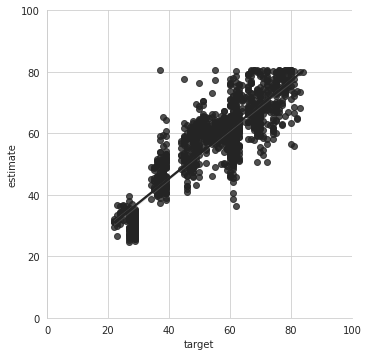

In [49]:
import seaborn as sns

#Draw Graphs（散布図)
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
figure = sns.lmplot(x='target', y='estimate', data=df)
plt.xlim(0,100)
plt.ylim(0,100)

# PATH = MODEL_PATH+'/'+DATASET_NAME+'.png'
# figure.savefig(PATH)

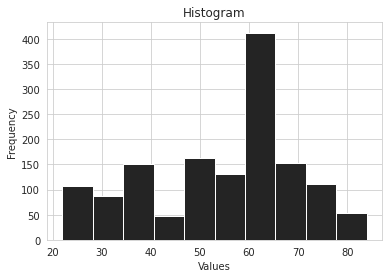

In [47]:
n, bins, patches=plt.hist(targets)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

#**Output CoreML**

In [ ]:
###########################
# Output as CoreML_example
###########################
import torch.nn as nn
import torch
import torchvision
!pip install --quiet coremltools
import coremltools as ct
import numpy as np
!pip install --quiet timm


# Load a pre-trained version of MobileNetV3

base_model = timm.create_model('mobilenetv3_large_100', pretrained=True)

class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            base_model,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)

# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()

# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
import urllib
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = class_labels[1:] # remove the first class which is background
assert len(class_labels) == 1000


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)

# Save model
mlmodel.save("MobileNetV3_pytorch.mlmodel")

     |████████████████████████████████| 1.5 MB 6.8 MB/s 


Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1466.69 ops/s]


In [ ]:
###########################
# Output as CoreML 飛ばして下さい
###########################

import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)


# # Convert to Core ML using the Unified Conversion API
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
#     classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
# )

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1744.69 ops/s]


In [ ]:
################################
### Output as CoreML (Tensor type) ###
################################
import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
    classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
)

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")

Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1717.72 ops/s]


#**Interference on CoreML model**

In [ ]:
# This script can be used in Mac only

##https://gist.github.com/ozgurshn/85cf74558d82c831827e12f015f752a1
##https://github.com/apple/coremltools/blob/master/examples/APIExamples.md
import coremltools
import numpy as np
import PIL.Image

# load a model whose input type is "Image"
model = coremltools.models.MLModel('/content/gravcont_mobilenetv3.mlmodel')

Height = 224  # use the correct input image height
Width = 224  # use the correct input image width


# Scenario 1: load an image from disk
def load_image(path, resize_to=None):
    # resize_to: (Width, Height)
    img = PIL.Image.open(path)
    if resize_to is not None:
        img = img.resize(resize_to, PIL.Image.ANTIALIAS)
    img_np = np.array(img).astype(np.float32)
    return img_np, img


# load the image and resize using PIL utilities
_, img = load_image('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_newPatient_250px/スライド1.jpeg', resize_to=(Width, Height))
out_dict = model.predict({'image': img})

# Scenario 2: load an image from a numpy array
shape = (Height, Width, 3)  # height x width x RGB
data = np.zeros(shape, dtype=np.uint8)
# manipulate numpy data
pil_img = PIL.Image.fromarray(data)
out_dict = model.predict({'image': pil_img})

Exception: ignored

##**Interference without Mac**

In [ ]:
#https://tvm.apache.org/docs/how_to/compile_models/from_coreml.html
!pip install --quiet apache-tvm
!pip install --quiet coremltools
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
import coremltools as cm
import numpy as np
from PIL import Image

     |████████████████████████████████| 42.8 MB 1.2 MB/s 


###**Load the model**

In [ ]:
model_url = "https://docs-assets.developer.apple.com/coreml/models/MobileNet.mlmodel"
model_file = "mobilenet.mlmodel"
model_path = download_testdata(model_url, model_file, module="coreml")
# Now you have mobilenet.mlmodel on disk
mlmodel = cm.models.MLModel(model_path)

###**Load the test image**

In [ ]:
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
# Mobilenet.mlmodel's input is BGR format
img_bgr = np.array(img)[:, :, ::-1]
x = np.transpose(img_bgr, (2, 0, 1))[np.newaxis, :]

###**Compile model on relay**

In [ ]:
target = "llvm"
shape_dict = {"image": x.shape}

# Parse CoreML model and convert into Relay computation graph
mod, params = relay.frontend.from_coreml(mlmodel, shape_dict)

with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "


In [ ]:
#Execute on TVM (これはサンプルの通り)
from tvm.contrib import graph_executor

dev = tvm.cpu(0)
dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# set inputs
m.set_input("image", tvm.nd.array(x.astype(dtype)))
# execute
m.run()
# get outputs
tvm_output = m.get_output(0)
top1 = np.argmax(tvm_output.numpy()[0])

###**Look up system name**

In [ ]:
synset_url = "".join(
    [
        "https://gist.githubusercontent.com/zhreshold/",
        "4d0b62f3d01426887599d4f7ede23ee5/raw/",
        "596b27d23537e5a1b5751d2b0481ef172f58b539/",
        "imagenet1000_clsid_to_human.txt",
    ]
)
synset_name = "imagenet1000_clsid_to_human.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synset = eval(f.read())
# You should see the following result: Top-1 id 282 class name tiger cat
print("Top-1 id", top1, "class name", synset[top1])

Top-1 id 282 class name tiger cat
